In [1]:
import numpy as np
import pandas as pd
from array import array
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns
import anndata as ad
import phagepy as pp
import scanpy as sc
import scipy.stats as ss
import scipy
import phagepy.analysis as analysis
import re
import os
from collections import Counter
import scipy.stats as stats
from Bio import SeqIO

In [2]:
# define output folder for figures
fig_dir='/data/kortbawi/Chagas/pub/final/final_fig_for_pub/'

In [3]:
# define directory for source and output files
dir='/data/kortbawi/Chagas/pub/final/'

# Read/write

In [4]:
# load processed adata objects
cbm = sc.read_h5ad(dir+'01_cbm.h5ad')
bd = sc.read_h5ad(dir+'01_bd.h5ad')

In [5]:
# load chagas-specific peptide files
chagas_pept_cbm=pd.read_csv(dir+'01_cbm_pept.csv', index_col=0, header=0)
chagas_pept_bd=pd.read_csv(dir+'01_bd_pept.csv', index_col=0, header=0)

In [6]:
# load peptide-to-gene mapping file
pep2gene=pd.read_csv(dir+'p2g_mapping.csv', index_col=0, header=0)
# rename index
pep2gene.index.names = ['peptide']

# Fig 2d - plot stage-specific peptides and proteins

In [7]:
# merge enriched peptide tables
merge_pept = pd.merge(chagas_pept_cbm, chagas_pept_bd, on='peptide', how='outer')
merge_pept.shape

(12978, 18)

In [8]:
merge_pept.head()

,no_test_x,no_ctrl_x,perc_test_x,perc_ctrl_x,gene_x,protein_x,refseq_id_x,seq_x,stage_x,no_test_y,no_ctrl_y,perc_test_y,perc_ctrl_y,gene_y,protein_y,refseq_id_y,seq_y,stage_y
peptide,,,,,,,,,,,,,,,,,,
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,10.9375,0.0,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",XP_802134.1,IKRLIGRKYSDATVQTDKKLLSYEVVADKDGKPKVQVEVGGKKKQFT,NaN
XP_802136.1_retrotransposon_hot_spot_(RHS)_protein_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag4,8.0,1.0,7.017544,0.877193,Tc00.1047053445777.10,"Retrotransposon hot spot (RHS) protein, putative",XP_802136.1,MCAWMKKNLEPDKQAEYWRMVKERIEKVGPIPRHIFREKIYINRMGA,ama_meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XP_802137.1_Na/H_antiporter-like_protein_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag8,9.0,1.0,7.894737,0.877193,Tc00.1047053510511.9,"Na/H antiporter-like protein, putative",XP_802137.1,CLKDSTWNIILKGVQLAALPIIVGPVFGFIQSYWLRHATGGIVKTCI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XP_802139.1_ATP-dependent_DEAD/H_RNA_helicase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,10.9375,0.0,Tc00.1047053509083.9,"ATP-dependent DEAD/H RNA helicase, putative",XP_802139.1,AFLKKNIPLEGVSNSKSHMMNPRYAEWRTHKMNAIARSYVSLITQKT,NaN
XP_802140.1_amino_acid_permease_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,7.0,0.0,6.140351,0.000000,Tc00.1047053503393.10,"Amino acid permease, putative",XP_802140.1,MTNAPIVEQIDDPLNDGVELVEDLQGQAGLPTGDRMDVAKIRIEKLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# there are now two stage columns - stage x and stage y
## want to collapse onto one stage column, keeping first value if same and keeping string if other column has NaN
merge_pept['stage_combined'] = np.where(
    merge_pept['stage_x'] == merge_pept['stage_y'],
    merge_pept['stage_x'],
    merge_pept['stage_x'].combine_first(merge_pept['stage_y'])
)
merge_pept.head()

,no_test_x,no_ctrl_x,perc_test_x,perc_ctrl_x,gene_x,protein_x,refseq_id_x,seq_x,stage_x,no_test_y,no_ctrl_y,perc_test_y,perc_ctrl_y,gene_y,protein_y,refseq_id_y,seq_y,stage_y,stage_combined
peptide,,,,,,,,,,,,,,,,,,,
XP_802134.1_heat_shock_protein_70_(HSP70)_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,10.9375,0.0,Tc00.1047053418069.10,"Heat shock protein 70 (HSP70), putative",XP_802134.1,IKRLIGRKYSDATVQTDKKLLSYEVVADKDGKPKVQVEVGGKKKQFT,NaN,NaN
XP_802136.1_retrotransposon_hot_spot_(RHS)_protein_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag4,8.0,1.0,7.017544,0.877193,Tc00.1047053445777.10,"Retrotransposon hot spot (RHS) protein, putative",XP_802136.1,MCAWMKKNLEPDKQAEYWRMVKERIEKVGPIPRHIFREKIYINRMGA,ama_meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ama_meta
XP_802137.1_Na/H_antiporter-like_protein_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag8,9.0,1.0,7.894737,0.877193,Tc00.1047053510511.9,"Na/H antiporter-like protein, putative",XP_802137.1,CLKDSTWNIILKGVQLAALPIIVGPVFGFIQSYWLRHATGGIVKTCI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
XP_802139.1_ATP-dependent_DEAD/H_RNA_helicase_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,10.9375,0.0,Tc00.1047053509083.9,"ATP-dependent DEAD/H RNA helicase, putative",XP_802139.1,AFLKKNIPLEGVSNSKSHMMNPRYAEWRTHKMNAIARSYVSLITQKT,NaN,NaN
XP_802140.1_amino_acid_permease_partial_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,7.0,0.0,6.140351,0.000000,Tc00.1047053503393.10,"Amino acid permease, putative",XP_802140.1,MTNAPIVEQIDDPLNDGVELVEDLQGQAGLPTGDRMDVAKIRIEKLN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# check that this did the right thing...
merge_pept[merge_pept['stage_x']=='ama_tryp_meta_epi'].head()

,no_test_x,no_ctrl_x,perc_test_x,perc_ctrl_x,gene_x,protein_x,refseq_id_x,seq_x,stage_x,no_test_y,no_ctrl_y,perc_test_y,perc_ctrl_y,gene_y,protein_y,refseq_id_y,seq_y,stage_y,stage_combined
peptide,,,,,,,,,,,,,,,,,,,
XP_802499.1_alpha_tubulin_[Trypanosoma_cruzi_strain_CL_Brener]_frag1,8.0,1.0,7.017544,0.877193,Tc00.1047053411235.9,Tubulin alpha chain,XP_802499.1,MREAICIHIGQAGCQVGNACWELFCLEHGIQPDGAMPSDKTIGVEDD,ama_tryp_meta_epi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ama_tryp_meta_epi
XP_802499.1_alpha_tubulin_[Trypanosoma_cruzi_strain_CL_Brener]_frag15,6.0,1.0,5.263158,0.877193,Tc00.1047053411235.9,Tubulin alpha chain,XP_802499.1,HKFDLMYSKRAFVHWYVGEGMEEGEFSEAREDLAALEKDYEEVGAES,ama_tryp_meta_epi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ama_tryp_meta_epi
XP_802499.1_alpha_tubulin_[Trypanosoma_cruzi_strain_CL_Brener]_frag16,10.0,0.0,8.771930,0.000000,Tc00.1047053411235.9,Tubulin alpha chain,XP_802499.1,FVHWYVGEGMEEGEFSEAREDLAALEKDYEEVGAESADMEGEEDVEE,ama_tryp_meta_epi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ama_tryp_meta_epi
XP_802499.1_alpha_tubulin_[Trypanosoma_cruzi_strain_CL_Brener]_frag3,15.0,0.0,13.157895,0.000000,Tc00.1047053411235.9,Tubulin alpha chain,XP_802499.1,GAGKHVPRAVFLDLEPTVVDEIRTGTYRQLFHPEQLISGKEDAANNY,ama_tryp_meta_epi,11.0,0.0,17.1875,0.0,Tc00.1047053411235.9,Tubulin alpha chain,XP_802499.1,GAGKHVPRAVFLDLEPTVVDEIRTGTYRQLFHPEQLISGKEDAANNY,ama_tryp_meta_epi,ama_tryp_meta_epi
XP_802499.1_alpha_tubulin_[Trypanosoma_cruzi_strain_CL_Brener]_frag7,15.0,1.0,13.157895,0.877193,Tc00.1047053411235.9,Tubulin alpha chain,XP_802499.1,YTVYPSPQVSTAVVEPYNSVLSTHSLLEHTDVAAMLDNEAIYDLTRR,ama_tryp_meta_epi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ama_tryp_meta_epi


In [11]:
# figure out how many peptides belong to each stage:
## count the occurrences of each unique value in the 'stage' column, excluding NaN
value_counts = merge_pept['stage_combined'].value_counts(dropna=False)

## convert the result to a new DataFrame
counts_df_merge = value_counts.reset_index()

## rename columns for better readability
counts_df_merge.columns = ['stage', 'count']
counts_df_merge

,stage,count
0,NaN,11445
1,ama_tryp_meta_epi,444
2,meta,208
3,ama_meta_epi,180
4,tryp,143
5,meta_epi,99
6,ama_meta,76
7,ama,64
8,ama_tryp_meta,54
9,tryp_meta,54


In [12]:
# figure out how many peptides belong to each stage in entire p2g file:
# count the occurrences of each unique value in the 'stage' column, excluding NaN
value_counts_all = pep2gene['stage'].value_counts(dropna=False)

# Convert the result to a new DataFrame
counts_p2g = value_counts_all.reset_index()

# Rename columns for better readability
counts_p2g.columns = ['stage', 'count']
counts_p2g.head()

,stage,count
0,NaN,208152
1,ama_tryp_meta_epi,4085
2,meta,3474
3,ama_meta_epi,2970
4,tryp,1626


In [13]:
# add a count of the number of peptides that are enriched in multiple human-interfacing stages (tryp and/or ama and/or meta but NOT epi)
## create a mask for rows that contain 'tryp', 'ama', or 'meta'
contains_tryp_ama_meta = counts_df_merge['stage'].str.contains('tryp|ama|meta', na=False)

## create a mask for rows that contain ONLY 'tryp', 'ama', or 'meta'
only_tryp_ama_meta = counts_df_merge['stage'].isin(['tryp', 'ama', 'meta'])

## identify rows that contain 'tryp', 'ama', or 'meta' but NOT only one of them
multiple_mask = contains_tryp_ama_meta & ~only_tryp_ama_meta

## sum the counts for rows matching the 'multiple' condition
multiple_sum = counts_df_merge[multiple_mask]['count'].sum()

## add the new row for 'multiple' to the df
new_row = pd.DataFrame({'stage': ['multiple'], 'count': [multiple_sum]})
counts_df_merge = pd.concat([counts_df_merge, new_row], ignore_index=True)

# Print the updated df
counts_df_merge.tail()

,stage,count
12,ama_tryp_epi,42
13,epi,31
14,ama_epi,30
15,tryp_epi,11
16,multiple,1087


In [14]:
# do the same for the pan-peptidome df
## create a mask for rows that contain 'tryp', 'ama', or 'meta'
contains_tryp_ama_meta = counts_p2g['stage'].str.contains('tryp|ama|meta', na=False)

## create a mask for rows that contain ONLY 'tryp', 'ama', or 'meta'
only_tryp_ama_meta = counts_p2g['stage'].isin(['tryp', 'ama', 'meta'])

## identify rows that contain 'tryp', 'ama', or 'meta' but NOT only one of them
multiple_mask = contains_tryp_ama_meta & ~only_tryp_ama_meta

## sum the counts for rows matching the 'multiple' condition
multiple_sum_p2g = counts_p2g[multiple_mask]['count'].sum()

## add the new row for 'multiple' to the df
new_row_p2g = pd.DataFrame({'stage': ['multiple'], 'count': [multiple_sum_p2g]})
counts_p2g = pd.concat([counts_p2g, new_row_p2g], ignore_index=True)

# Print the updated df
counts_p2g.tail()

,stage,count
12,ama_tryp,439
13,ama_epi,311
14,ama_tryp_epi,245
15,tryp_epi,120
16,multiple,13113


In [15]:
# calculate % of all peptides for that stage
## merge both dfs on the 'stage' column
merged_df_net = pd.merge(counts_df_merge, counts_p2g, on='stage', suffixes=('_chagas', '_p2g'))

## calculate the percentage of 'counts' in chagas-specific peptides relative to total counts in the peptidome
merged_df_net['percent_relative'] = (merged_df_net['count_chagas'] / merged_df_net['count_p2g']) * 100
merged_df_net.tail()

,stage,count_chagas,count_p2g,percent_relative
12,ama_tryp_epi,42,245,17.142857
13,epi,31,744,4.166667
14,ama_epi,30,311,9.646302
15,tryp_epi,11,120,9.166667
16,multiple,1087,13113,8.289484


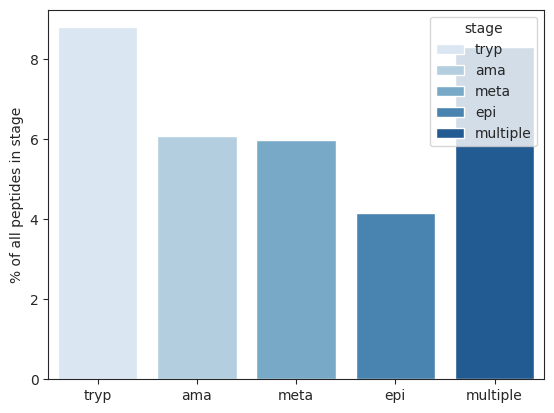

In [16]:
# plot percent of enriched peptides out of all peptides in each stage
sns.set_style("ticks")

# specify order for plot
order = ['tryp', 'ama', 'meta', 'epi', 'multiple']
palette = sns.color_palette("Blues", n_colors=5)

# plot stages
ax = sns.barplot(data=merged_df_net, x='stage', y='percent_relative',
                 hue='stage',
                 palette = palette, 
                 order = order,
                 hue_order=order
                )

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams['axes.linewidth'] = .75

ax.set_xlabel("")
ax.set_ylabel("% of all peptides in stage")

plt.savefig(fig_dir+'fig_2d.pdf', dpi=300 , bbox_inches="tight")
plt.show()